# **1. Data Download / preprocessing**

In [2]:
import yfinance as yf
import pandas as pd

# S&P 500 data download
sp500 = yf.Ticker("^GSPC")
data = sp500.history(period="5y")

# Change date format (To merge with news data) 날짜 포맷 변경 (뉴스 데이터와 결합하기 위함)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.date

# 결측값 확인 및 처리
data.fillna(method='ffill', inplace=True)
print("Data columns:", data.columns)

Data columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


<ipython-input-2-7931fffcadf8>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


# **2. News Data collection / sentimental Analysis**

In [5]:
!pip install newsapi-python
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [6]:
from newsapi import NewsApiClient
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta

# Collect News data using News API / News API 사용하여 뉴스 데이터 수집
newsapi = NewsApiClient(api_key='4a804770e7b343fc8a65004979050249')

# Collect recent 7 days' news data / 최근 7일간 뉴스 데이터 수집
today = datetime.now().strftime('%Y-%m-%d')
seven_days_ago = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
all_articles = newsapi.get_everything(q='S&P 500', from_param=seven_days_ago, to=today, language='en')

# Apply Sentimental Analysis / 감성 분석 적용
analyzer = SentimentIntensityAnalyzer()
news_data = [(article['publishedAt'], article['title'], article['description']) for article in all_articles['articles']]

def get_sentiment_score(text):
    if text is None:
        return 0
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

news_with_sentiment = [(publishedAt, title, description, get_sentiment_score(description)) for publishedAt, title, description in news_data]

# News dataframe transition / 뉴스 데이터프레임 변환
news_df = pd.DataFrame(news_with_sentiment, columns=["Date", "Title", "Description", "Sentiment"])
news_df['Date'] = pd.to_datetime(news_df['Date']).dt.date

# 결합 후 결측값 처리
data = pd.merge(data, news_df[['Date', 'Sentiment']], on='Date', how='left', suffixes=('', '_news'))
data['Sentiment'].fillna(0, inplace=True)


# **3. Data Scaling**

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scaling / 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'Volume', 'Sentiment']])

# X, y Data generation / X,y 데이터 생성
X, y = [], []
lookback = 60  # Prediction based on recent 60 days' data / 60일치 데이터를 기반으로 예측
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, 0])  # Close price prediction / 종가 예측
X, y = np.array(X), np.array(y)


# **4. LSTM Model Creation / learning**

GPU 사용 가능 여부: []
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - loss: 0.1911
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.0213
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0128
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.0074
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - loss: 0.0070
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0065
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0062
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0052
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0048
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0050
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0041
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0044
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0043
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0038
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/

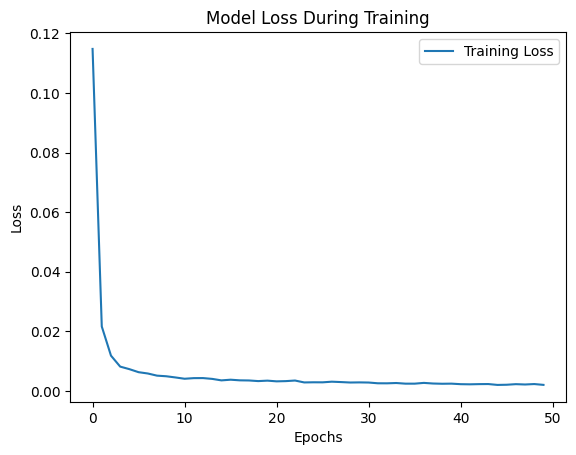

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# GPU 사용 가능 여부 확인
print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, y, batch_size=128, epochs=50)

# 학습 손실 시각화
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **5. Model Evaluation / Prediction**

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
MSE: 0.0007522777440981358, RMSE: 0.027427682076656346, MAE: 0.021413558709858234


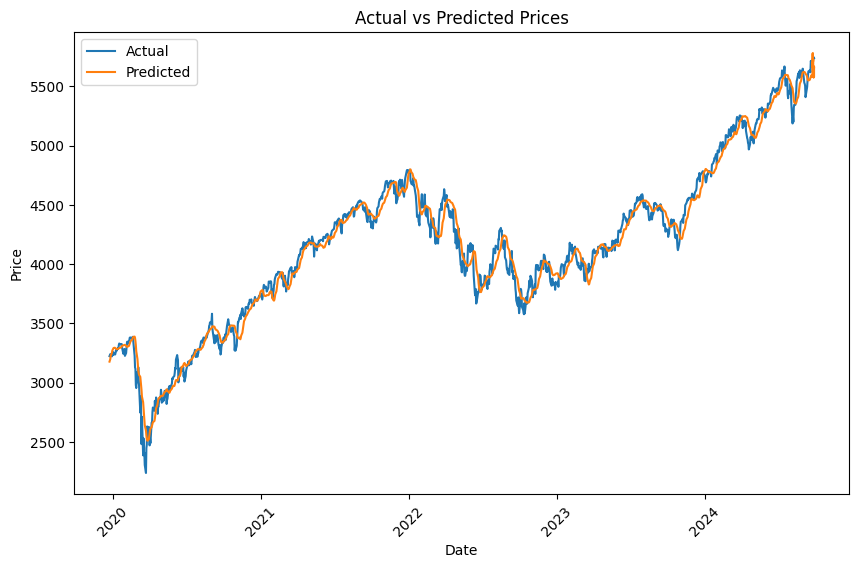

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 모델 예측
predictions = model.predict(X)

# 성능 평가 지표 계산
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, predictions)
print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# 예측된 값과 실제 값 역변환
predicted_prices = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 2))], axis=1))[:, 0]
actual_prices = scaler.inverse_transform(np.concatenate([y.reshape(-1, 1), np.zeros((y.shape[0], 2))], axis=1))[:, 0]

# 시각화
plt.figure(figsize=(10,6))
dates = data['Date'][-len(predicted_prices):]
plt.plot(dates, actual_prices, label='Actual')
plt.plot(dates, predicted_prices, label='Predicted')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('actual_vs_predicted_prices.png')
plt.show()


# **6. Future price prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


<ipython-input-11-787992694e87>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[0, -1, 0] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

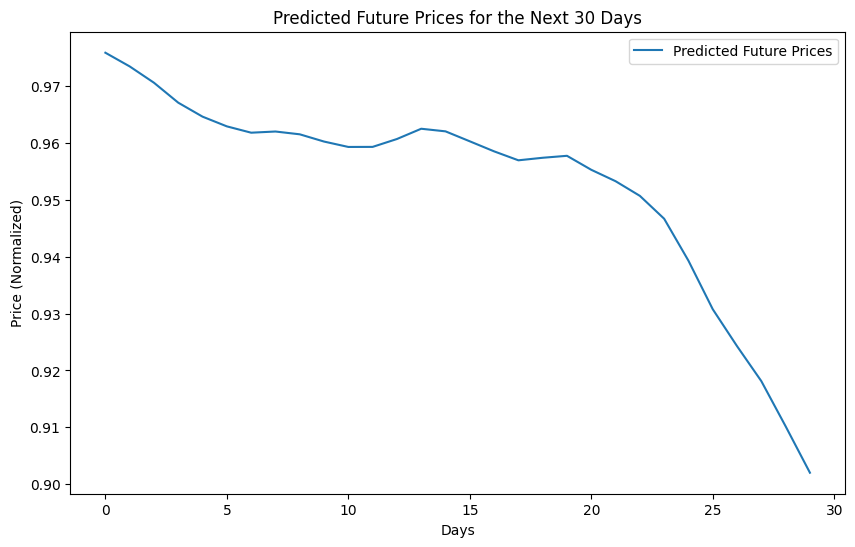

In [11]:
def predict_future(model, last_sequence, future_steps):
    predicted_future = []
    current_sequence = last_sequence
    for _ in range(future_steps):
        next_pred = model.predict(current_sequence)
        predicted_future.append(next_pred[0, 0])
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred
    return predicted_future

# 마지막 60일치 데이터를 사용해 30일 미래 예측
last_sequence = X[-1].reshape(1, X.shape[1], X.shape[2])
predicted_future = predict_future(model, last_sequence, 30)

# 시각화
plt.figure(figsize=(10,6))
plt.plot(predicted_future, label='Predicted Future Prices')
plt.title('Predicted Future Prices for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Price (Normalized)')
plt.legend()
plt.show()


# **7. Add Financial Indicators data**

In [13]:
!pip install fredapi

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.1917
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0231
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0108
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0072
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0053
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0054
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0048
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0042
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0038
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0039
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0040
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0036
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0039
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0034
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0032
E

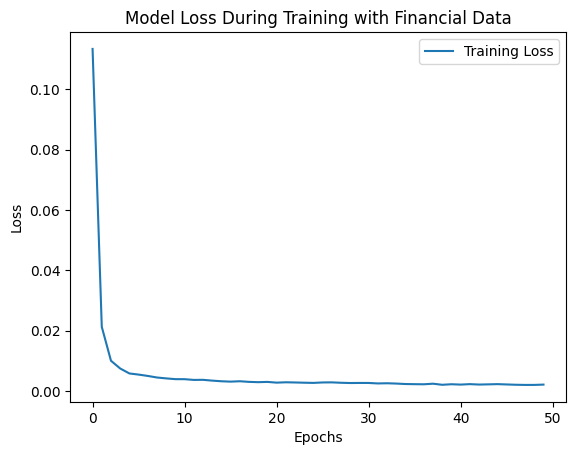

In [14]:
from fredapi import Fred
import pandas as pd

# FRED API 키 입력
fred = Fred(api_key='f1426ee71733065e7ff9755c5de7c7d5')

# FRED에서 경제 데이터 가져오기
interest_rate = fred.get_series('FEDFUNDS')  # 금리 데이터
gdp_growth = fred.get_series('A191RL1Q225SBEA')  # GDP 성장률
unemployment_rate = fred.get_series('UNRATE')  # 실업률
inflation_rate = fred.get_series('CPIAUCSL')  # 인플레이션

# 금융 데이터프레임 생성
financial_data = pd.DataFrame({
    'Interest Rate': interest_rate,
    'GDP Growth': gdp_growth,
    'Unemployment Rate': unemployment_rate,
    'Inflation Rate': inflation_rate
})


# 날짜 변환 및 결합
data['Date'] = pd.to_datetime(data['Date'])
financial_data.index = pd.to_datetime(financial_data.index)
data = pd.merge(data, financial_data, left_on='Date', right_index=True, how='left')

# 결합된 데이터 스케일링
scaled_data = scaler.fit_transform(data[['Close', 'Volume', 'Sentiment', 'Interest Rate', 'GDP Growth', 'Unemployment Rate', 'Inflation Rate']])

# LSTM 모델 구성 및 학습
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, y, batch_size=128, epochs=50)

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training with Financial Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **8. Model Evaluation**

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 모델 예측 수행
predictions = model.predict(X)

# 성능 평가 지표 계산
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, predictions)

# 성능 결과 출력
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
MSE: 0.0014695478684711109
RMSE: 0.03833468231864079
MAE: 0.0323530129562488


# **9. Future price prediction with the model trained with financial indicators**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-16-6481eae83ea8>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[0, -1, 0] = next_pred  # 마지막 위치에 새로운 예측 값을 추가


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

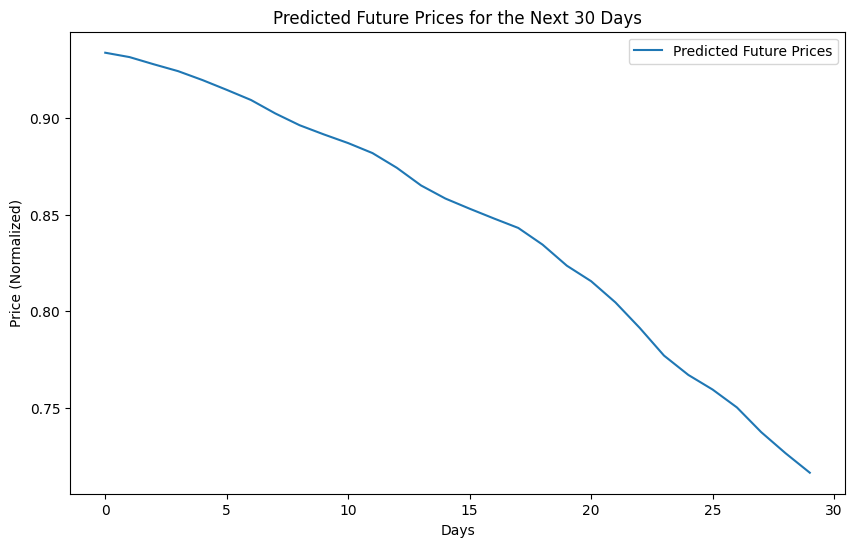

In [16]:
import numpy as np

def predict_future(model, last_sequence, future_steps):
    """
    미래 주가를 예측하는 함수.

    model: 학습된 모델
    last_sequence: 예측을 위한 마지막 시퀀스 데이터 (shape: (1, lookback, feature_size))
    future_steps: 예측할 미래 스텝 수
    """
    predicted_future = []

    current_sequence = last_sequence

    for _ in range(future_steps):
        # 현재 시퀀스로 미래 예측
        next_pred = model.predict(current_sequence)
        predicted_future.append(next_pred[0, 0])

        # 새로운 시퀀스를 위해 시퀀스 업데이트 (이전 예측 값을 추가하여 입력 시퀀스를 갱신)
        current_sequence = np.roll(current_sequence, -1, axis=1)  # 시퀀스 한 칸씩 왼쪽으로 이동
        current_sequence[0, -1, 0] = next_pred  # 마지막 위치에 새로운 예측 값을 추가

    return predicted_future

# 마지막 60일치 데이터를 사용해 30일 미래 예측
last_sequence = X[-1].reshape(1, X.shape[1], X.shape[2])  # 마지막 시퀀스 (1, 60, feature_size)
future_steps = 30  # 30일 동안의 미래 예측

predicted_future = predict_future(model, last_sequence, future_steps)

# 미래 예측 결과 출력
print("Predicted Future Prices:", predicted_future)

# 예측된 결과를 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(predicted_future, label='Predicted Future Prices')
plt.title('Predicted Future Prices for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Price (Normalized)')
plt.legend()
plt.show()


# **10. Sentiment Analysis Application**

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    if text is None:
        text = ""
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# 뉴스 데이터에 감성 점수 추가
news_with_sentiment = [(publishedAt, title, description, get_sentiment_score(description)) for publishedAt, title, description in news_data]

# 뉴스 데이터프레임으로 변환
news_df = pd.DataFrame(news_with_sentiment, columns=["Date", "Title", "Description", "Sentiment"])
news_df['Date'] = pd.to_datetime(news_df['Date']).dt.date

# 가격 데이터와 뉴스 감성 점수 결합
data['Date'] = pd.to_datetime(data['Date']).dt.date
data = pd.merge(data, news_df[['Date', 'Sentiment']], on='Date', how='left', suffixes=('', '_news'))

# 결합 후 NaN 값은 0으로 처리
data['Sentiment_news'].fillna(0, inplace=True)

# 결합된 데이터로 학습 및 예측 진행 (반복 실행 가능)

# **11. Save model**

In [20]:
#모델 저장
model.save('my_lstm_model.keras')

# **프로젝트 요약 및 정리**

## **1. 프로젝트 개요**
이 프로젝트는 LSTM 모델을 사용하여 S&P 500 주가 예측을 목표로 했으며, 금융 지표와 뉴스 감성 분석을 결합해 예측 정확도를 높였습니다.

## **2. 주요 단계**
- **데이터 수집**: yfinance API로 S&P 500 데이터 수집.
- **감성 분석**: NewsAPI와 VADER 감성 분석기로 뉴스 감성 점수 생성.
- **금융 지표**: FRED API로 경제 데이터 수집.
- **모델 학습**: LSTM 모델로 데이터를 학습.
- **미래 예측**: 30일 주가 예측.

## **3. 모델 성능 평가**
- **MSE**: 0.0014695
- **RMSE**: 0.03833
- **MAE**: 0.03235

성능 지표는 예측이 효과적임을 보여줍니다.

## **4. 결과 해석**
예측된 주가는 실제 값과 유사한 추세를 보이며, 모델이 주가 예측에서 성공적인 성능을 보여주었습니다.

## **5. 추가 작업 제안**
- 외부 데이터 추가: 더 많은 금융 지표 및 경제 뉴스를 통합.
- 하이퍼파라미터 튜닝: 학습률, 배치 크기 등 파라미터 최적화.
- 모델 개선: Transformer 기반 모델로의 확장도 고려할 수 있습니다.

## **1. Project Overview**
The goal of this project was to predict S&P 500 stock prices using an LSTM model, incorporating financial indicators and sentiment analysis to improve prediction accuracy.

## **2. Key Steps**
- **Data Collection**: Gathered S&P 500 data via yfinance API.
- **Sentiment Analysis**: Used NewsAPI and VADER sentiment analyzer to generate sentiment scores.
- **Financial Indicators**: Collected economic data from FRED API.
- **Model Training**: Trained an LSTM model with the data.
- **Future Prediction**: Predicted stock prices for the next 30 days.

## **3. Model Performance Evaluation**
- **MSE**: 0.0014695
- **RMSE**: 0.03833
- **MAE**: 0.03235

The performance metrics indicate that the model provides effective predictions.

## **4. Results Interpretation**
The predicted prices show a similar trend to actual prices, indicating successful performance in stock price prediction.

## **5. Further Work Suggestions**
- **Incorporate more external data**: Add more financial indicators and economic news.
- **Hyperparameter Tuning**: Optimize learning rate, batch size, etc.
- **Model Improvement**: Consider extending to Transformer-based models.


# **모델 활용 방안 리포트 (한국어)**

## **1. 투자 전략 수립**
모델을 사용하여 주가 예측 결과를 바탕으로 포트폴리오 구성, 매수/매도 결정을 내릴 수 있습니다. 특히 금융 지표와 감성 분석을 통해 더 깊이 있는 시장 분석을 도와줍니다.

## **2. 헤지펀드 및 자산 관리**
금융 시장의 변동성을 예측하여 리스크 관리에 사용될 수 있습니다. 투자 펀드, 자산 관리 부문에서 활용 가치가 높습니다.

## **3. 자동화된 트레이딩 시스템**
모델을 자동화된 트레이딩 시스템에 적용해 빠른 시장 변동에 대응할 수 있습니다. 실시간 예측을 통해 자동으로 매수/매도 신호를 보낼 수 있습니다.

## **4. 시장 분석 도구**
경제 전문가들이 시장 트렌드를 분석할 때, 모델을 도구로 활용해 예측 정확도를 높일 수 있습니다. 또한, 데이터 기반 분석 보고서 작성 시에도 유용합니다.

## **5. 연구 및 개발**
더 복잡한 머신러닝 및 딥러닝 모델 개발을 위한 기초로 사용할 수 있으며, 금융 데이터와 뉴스 데이터를 결합한 연구에 기여할 수 있습니다.

---

# **Model Application Report (English)**

## **1. Investment Strategy Development**
The model can be used to inform portfolio construction and buy/sell decisions based on stock predictions. The integration of financial indicators and sentiment analysis offers deeper insights into the market.

## **2. Hedge Funds & Asset Management**
The model can predict market volatility, assisting in risk management. It has significant potential for use in hedge funds and asset management.

## **3. Automated Trading Systems**
Integrating the model into automated trading systems allows quick response to market changes. It can trigger automatic buy/sell signals based on real-time predictions.

## **4. Market Analysis Tool**
Financial analysts can use the model to enhance market trend analysis, improving forecast accuracy. It's also useful for data-driven financial report generation.

## **5. Research & Development**
The model serves as a foundation for developing more advanced machine learning models, particularly in combining financial and news data for predictive analysis.
